# Signal super resolution

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [34]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [3]:
import pandas as pd
columns = ["Method", "MSE", "SSIM", "PSNR", "Time (s)"]
df = pd.DataFrame(columns = columns)
df.head()

Empty DataFrame
Columns: [Method, MSE, SSIM, PSNR, Time (s)]
Index: []

In [4]:
import os
import torch
import numpy as np

In [5]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
labels = ["MI", "STTC", "CD", "HYP", "NORM"]

In [7]:
in_colab = False
try:
    import google.colab
    in_colab = True
except:
    in_colab = False
in_colab

False

In [8]:
if in_colab:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  %cd "drive/MyDrive/Colab Notebooks/ECG_SuperResolution"
  !ls

In [9]:
dict_windows_test_hr = {}
dict_windows_test_lr = {}
dict_windows_train_lr = {}
dict_windows_test_lr_n = {}
dict_windows_train_lr_n = {}
dict_windows_train_hr = {}
path = os.getcwd()+os.sep+"pt_data"+os.sep

for label in labels:

    filename = path + "test_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_test_hr[label] = hr_data

    filename = path + "test_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr[label] = lr_data
    
    
    filename = path + "test_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr_n[label] = lr_data

    filename = path + "train_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_train_hr[label] = hr_data

    filename = path + "train_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr[label] = lr_data
    
    filename = path + "train_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr_n[label] = lr_data

dict_windows_train = dict_windows_train_lr
dict_windows_test = dict_windows_test_lr

In [10]:
fs_lr = 50
fs_hr = 500

In [1]:
from scipy import interpolate

In [13]:
def compute_sr(signals, method, signals_hr = None, nchs = 12):
    signals_sr = []
    n = len(signals)
    for i, signal in enumerate(signals):
        print("\r", i+1, "/", n, end = "")
        signal = signal.cpu().detach().numpy()
        if signals_hr is None:
            signal_sr = method(signal, nchs=nchs)
        else:
            signal_hr = signals_hr[i]
            signals_hr = method(signal, signal_hr, nchs=nchs)
        if isinstance(signal_sr, (np.ndarray, np.generic) ):
            signal_sr = torch.from_numpy(signal_sr)
        signals_sr.append(signal_sr)
    signals_sr = torch.stack(signals_sr)
    width_sr = signals_sr.shape[-1]
    width_lr = signal.shape[-1]
    if method != "our proposed (S)":
        if width_lr == width_sr:
            signals_sr = interpolate_sr(signals_sr)
    return signals_sr

In [14]:
from torch.functional import F
def compute_mse(signals_sr, signals_hr):
    losses = []
    for i, signal_sr in enumerate(signals_sr):
        signal_sr = signal_sr.cpu()
        signal_hr = signals_hr[i].cpu()
        mse_loss = F.mse_loss(signal_sr, signal_hr)
        losses.append(mse_loss.item())
    return losses, np.mean(losses)

In [15]:
def interpolate_sr(signals, fs_lr=50, fs_hr = 500, nchs=12, mode = 'cubic'):
    # Interpolation to 500 Hz
    t_low_res = np.arange(0, 5, 1/fs_lr)
    t_high_res = np.arange(0, 5, 1/fs_hr)  # 500 Hz sampling rate
    signals_sr = []
    for signal in signals:
        f_interp = interpolate.interp1d(t_low_res, signal, kind=mode, fill_value="extrapolate")
        signal_sr = f_interp(t_high_res)
        if isinstance(signal_sr, (np.ndarray, np.generic) ):
            signal_sr = torch.from_numpy(signal_sr)
        signals_sr.append(signal_sr)
    signals_sr = torch.stack(signals_sr)
    return signals_sr

In [16]:
if in_colab:
  !pip install torchinfo
  !pip install neurokit2
  !pip install pytorch_lightning

In [17]:
if in_colab:
  !pip install ssqueezepy
  !pip install wfdb
  !pip install pycwt

In [18]:
def ibp(signal, nchs = 12):
    # Iterative Back Projection (IBP) algorithm

    if signal.ndim == 3:
        signal = signal[0]
    if signal.ndim == 4:
        signal = signal[0][0]

    signal_sr = signal.copy()
    num_iterations = 10
    eps = 1e-10  # Small value to avoid division by zero

    if isinstance(signal_sr, np.ndarray):
        signal_sr = torch.from_numpy(signal_sr)
    if signal_sr.ndim == 1:
        if torch.is_tensor(signal_sr):
            signal_sr = torch.unsqueeze(signal_sr, dim = 0)
    if torch.is_tensor(signal_sr):
        signal_sr = signal_sr.detach().numpy()

    #print(signal.shape, signal_sr.shape, nchs)
    for _ in range(num_iterations):
        for ch in range(nchs):
            difference = signal[ch] - signal_sr[ch]
            scaling_factor = np.dot(signal_sr[ch], difference) / (np.dot(difference, difference) + eps)
            signal_sr[ch] = scaling_factor * difference
    return signal_sr

In [19]:
if in_colab:
  !pip install pyunlocbox

In [20]:
import pyunlocbox

# Define functions for pyunlocbox
def cost_function(x, signal):
    return 0.5 * np.linalg.norm(x - signal.flatten())**2

# Define the proximal operator for the L1 norm
def prox(x, gamma):
    return np.maximum(0, x - gamma) + np.minimum(0, x + gamma)


def non_uniform_sr(signal, nchs=12):

    signal = signal[0]
    lr_shape = signal.shape
    # Set up the optimization problem
    f1 = pyunlocbox.functions.norm_l2()
    f2 = pyunlocbox.functions.func()
    f2._eval = lambda x: cost_function(x, signal)
    f2._prox = lambda x, gamma: prox(x, gamma)

    F = [f1, f2]
    solver = pyunlocbox.solvers.forward_backward(step=1.0)

    # Run the optimization
    x0 = np.zeros_like(signal.flatten())
    x_hat = pyunlocbox.solvers.solve([f1, f2], x0, solver)

    # Reshape the result to the original image size
    x_hat = x_hat["sol"]
    signal_sr = x_hat.reshape(lr_shape)
    signal_sr = torch.from_numpy(signal_sr).float()
    return signal_sr

In [21]:
def ssim_2d(signal1, signal2):
    """
    Compute the Structural Similarity Index (SSIM) for two-dimensional signals.

    Parameters:
    - signal1, signal2: Input signals.

    Returns:
    - ssim_index: Structural Similarity Index between the two signals.
    """

    # Ensure the signals have the same shape
    if signal1.shape != signal2.shape:
        raise ValueError("Input signals must have the same shape")

    # Constants for SSIM calculation
    C1 = (0.01 * np.amax(signal1) - np.amin(signal1))**2
    C2 = (0.01 * np.amax(signal2) - np.amin(signal2))**2

    # Mean and variance
    mu1 = np.mean(signal1)
    mu2 = np.mean(signal2)

    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = np.var(signal1)
    sigma2_sq = np.var(signal2)
    sigma12 = np.cov(signal1.flatten(), signal2.flatten())[0, 1]

    # SSIM calculation
    num = (2 * mu1_mu2 + C1) * (2 * sigma12 + C2)
    den = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)

    #print(num, den)
    ssim_index = num / den

    return ssim_index

In [22]:
from scipy.fftpack import fft, ifft

# Frequency Domain Super-Resolution
def fft_sr(signal, nchs=12):
    signal = signal[0]
    N = signal.shape[-1]
    signal_sr = ifft(fft(signal, N * 10)[:N])
    signal_sr = torch.from_numpy(signal_sr).float()
    #print(signal_sr.shape)
    return signal_sr

In [23]:
def compute_ssim(signals_sr, signals_hr):

    ssims = []
    for i, signal_sr in enumerate(signals_sr):
        signal_sr = signal_sr.cpu()
        signal_hr = signals_hr[i].cpu()
        signal_sr = torch.squeeze(signal_sr, dim =0).cpu().detach().numpy()
        signal_hr = torch.squeeze(signal_hr, dim =0).cpu().detach().numpy()
        ssim = ssim_2d(signal_hr, signal_sr)
        ssims.append(ssim)
    return ssims, np.mean(ssims)

In [24]:
def psnr_2d(original, reconstructed):
    """
    Compute Peak Signal-to-Noise Ratio (PSNR) for two-dimensional signals.

    Parameters:
    - original: Original signal.
    - reconstructed: Reconstructed signal.

    Returns:
    - psnr_value: PSNR value between the original and reconstructed signals.
    """

    # Ensure the signals have the same shape
    if original.shape != reconstructed.shape:
        raise ValueError("Input signals must have the same shape")

    # Calculate the mean squared error
    mse = np.mean((original - reconstructed)**2)

    # The maximum possible pixel value (assuming the signal is in the range [0, 1])
    max_pixel_value = 1.0

    # Calculate PSNR
    psnr_value = 10 * np.log10((max_pixel_value**2) / mse)

    return psnr_value

In [25]:
def compute_psnr(signals_hr, signals_sr):

    psnrs = []
    for i, signal_sr in enumerate(signals_sr):
        signal_sr = signal_sr.cpu()
        signal_hr = signals_hr[i].cpu()
        signal_sr = torch.squeeze(signal_sr, dim =0).cpu().detach().numpy()
        signal_hr = torch.squeeze(signal_hr, dim =0).cpu().detach().numpy()
        psnr = psnr_2d(signal_hr, signal_sr)
        psnrs.append(psnr)
    return psnrs, np.mean(psnrs)

In [26]:
def sr_our_proposed_onlysignals(signal, nchs=12):

    global model
    global device
    signal = torch.from_numpy(signal).to(device)
    if signal.ndim == 2:
        signal = signal.unsqueeze(dim = 0)
    if signal.ndim == 3:
        signal = signal.unsqueeze(dim = 0)
    pred = model([signal, None, None, None])
    signal_sr = pred[1]
    if signal_sr.ndim == 2:
        signal_sr = signal_sr.unsqueeze(dim = 0)
    signal_sr = signal_sr.cpu().detach().numpy()
    
    #print(signal_sr.shape)
    del pred
    del signal
    return signal_sr

In [28]:
from scipy.signal import resample as sc_resample
import gc

def scipy_resample(signal, nchs = 12, size = 2500):

    gc.collect()
    signal_sr = np.zeros((nchs, size))
    for ch in range(nchs):
        signal_ch = signal[0, ch]
        signal_sr[ch, :]= sc_resample(signal_ch, size)
    #print(signal_sr.shape)
    return signal_sr

In [29]:
from functions import *

In [30]:
def filter_interp(signals, nchs = 12):
        
    signals = torch.from_numpy(signals)
    interp_datas = []
    for signal in signals:
        filtered_data = myfilter(0.5, signal, powerline = None)
        interp_data = interpolate_sr(filtered_data, fs_lr=50, fs_hr = 500, nchs=nchs, mode = 'cubic')
        interp_datas.append(interp_data)
    
    interp_datas = torch.stack(interp_datas)
    return interp_datas

In [31]:
methods = ["filter + interpolation", "interpolation", "scipy resample", "wavelets sr", "fft sr", "our proposed (S)"]
functions = [filter_interp, interpolate_sr, scipy_resample, wav_sr, fft_sr, sr_our_proposed_onlysignals]
methods = {method:functions[i] for i, method in enumerate(methods)}

In [32]:
device = "cuda:0"
model_path = os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr.pt"
model = torch.load(model_path)
model = model.to(device)
model.eval()

VAE1d_SR_multimodal(
  (encoder): Encoder1d(
    (encoder): Sequential(
      (0): EncoderBlock1d(
        (conv1d_in): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(12, 192, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderBlock1d(
        (conv1d_in): Conv1d(192, 384, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(384, 768, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder1d(
    (decoder): Sequential(
      (0): DecoderBlock1d(
        (conv1d_in): ConvTranspose1d(768, 768, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=

In [33]:
gc.collect()

9

filter + interpolation
 1088 / 1088

interpolation
 1088 / 1088

scipy resample
 1088 / 1088

wavelets sr
 1088 / 1088

fft sr
 355 / 1088

C:\Users\Utente\AppData\Local\Temp\ipykernel_21680\1478858825.py:8: UserWarning:

Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:276.)



 1088 / 1088

our proposed (S)
 1088 / 1088



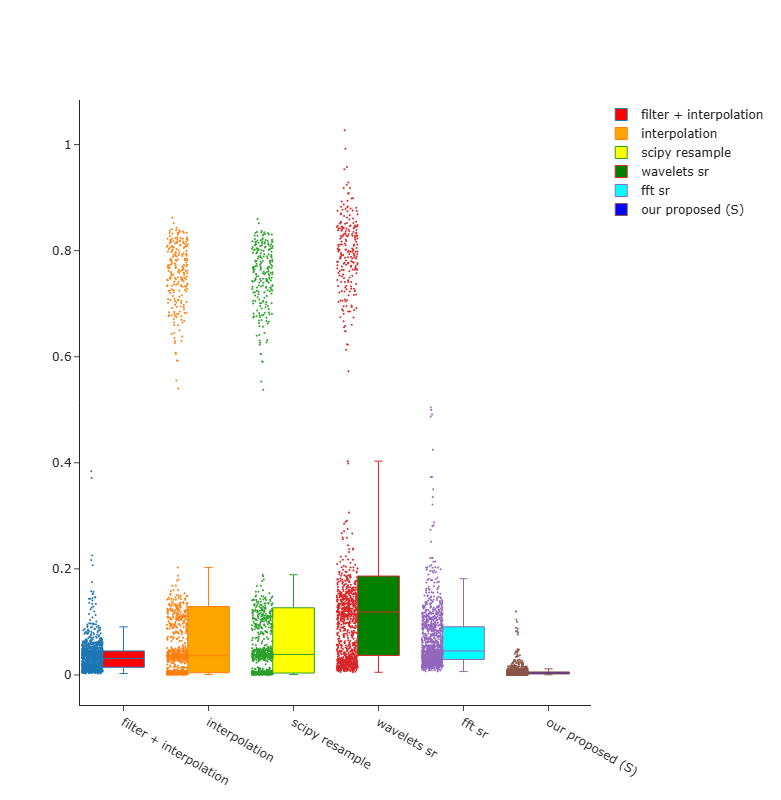

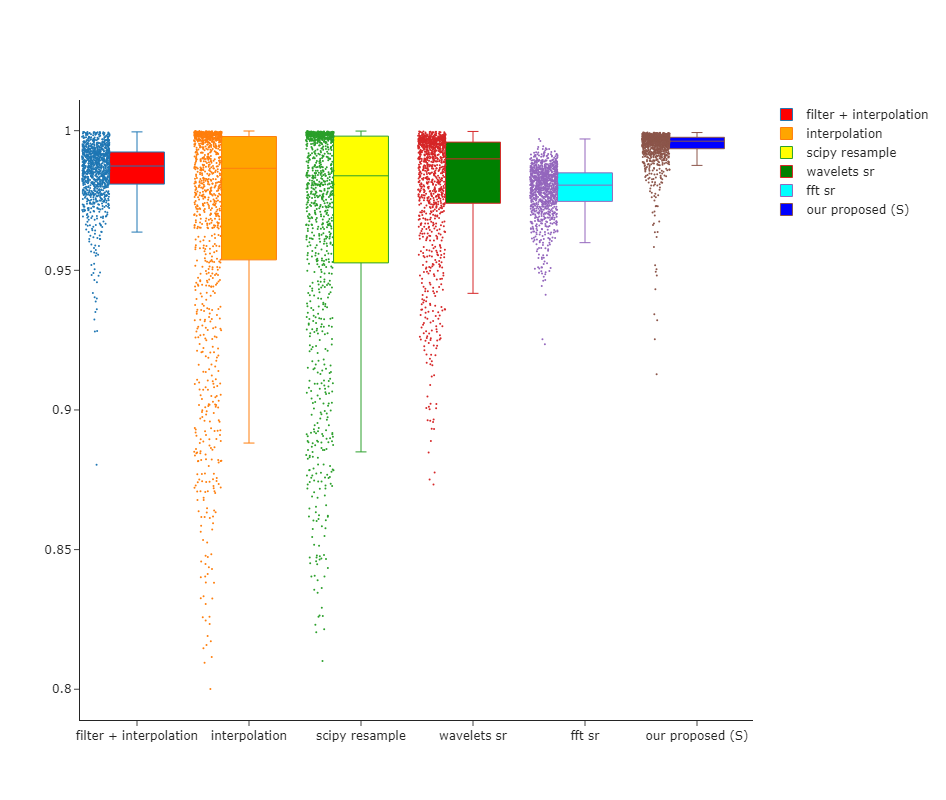

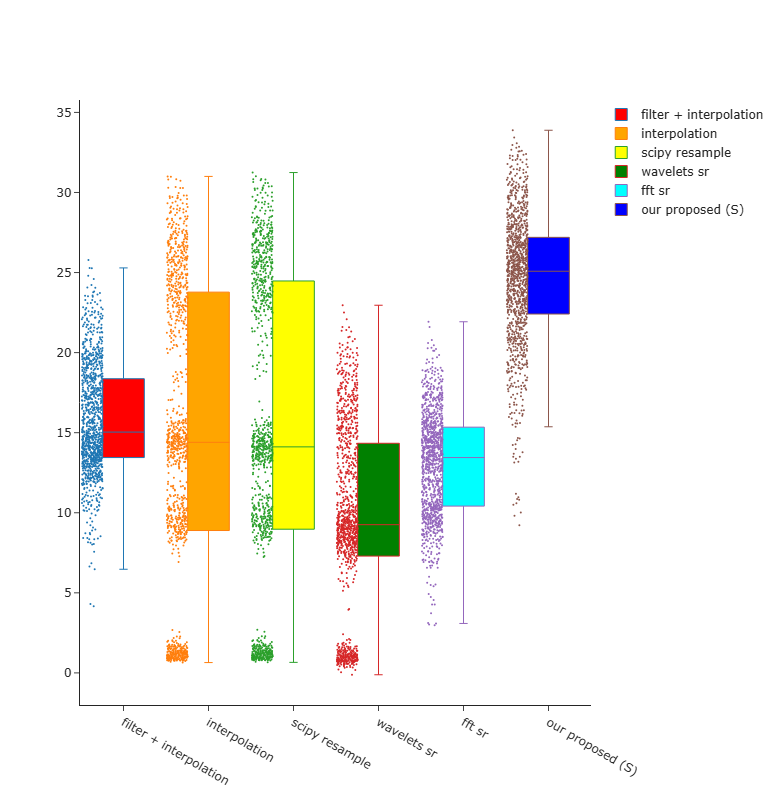

In [40]:
import time
import plotly 
from plotly import graph_objects as go 

df = pd.DataFrame(columns = columns)
model = model.eval()
model = model.to(device)
colors = ["red", "orange", "yellow", "green", "cyan", "blue"]
fig = go.Figure()
fig1 = go.Figure()
fig2 = go.Figure()

label = "MI"
signals_test = dict_windows_test_lr_n[label]
signals_test_hr = dict_windows_test_hr[label]

for i, (method, function) in enumerate(methods.items()):

    print(method)

    color = colors[i]
    
    t0 = time.time()
    #compute method sr from low res
    if method == "sparse_representation_sr":
        signals_test_sr = compute_sr(signals_test, function, signals_hr = signals_test_hr)
    else:
        signals_test_sr = compute_sr(signals_test, function)

    if signals_test_sr.ndim == 3:
        signals_test_sr = torch.unsqueeze(signals_test_sr, dim = 1)
    
    #print(signals_test_sr.shape, signals_test_hr.shape)
    #compute mse
    mses, mse = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
    tend = time.time()
    ex_time = round(tend-t0, 3)
    values = [method, mse, ssim, psnr, ex_time]
    df.loc[i] = values
    
    fig.add_trace(go.Box(
            y=mses,
            name=method,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,
            marker_size=2,
            line_width=1)
    )
    
    fig1.add_trace(go.Box(
            y=ssims,
            name=method,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,
            marker_size=2,
            line_width=1)
    )
    
    fig2.add_trace(go.Box(
            y=psnrs,
            name=method,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=color,
            marker_size=2,
            line_width=1)
    )
    
    del signals_test_sr
    print("\n")
    
fig.update_layout(autosize = False, width = 800, height = 800, template = "simple_white")
fig.show() 
fig1.update_layout(autosize = False, width = 800, height = 800, template = "simple_white")
fig1.show() 
fig2.update_layout(autosize = False, width = 800, height = 800, template = "simple_white")
fig2.show() 

In [41]:
def normalize(data):
    from sklearn.preprocessing import MinMaxScaler
    data = np.array(data).reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data[:, 0]

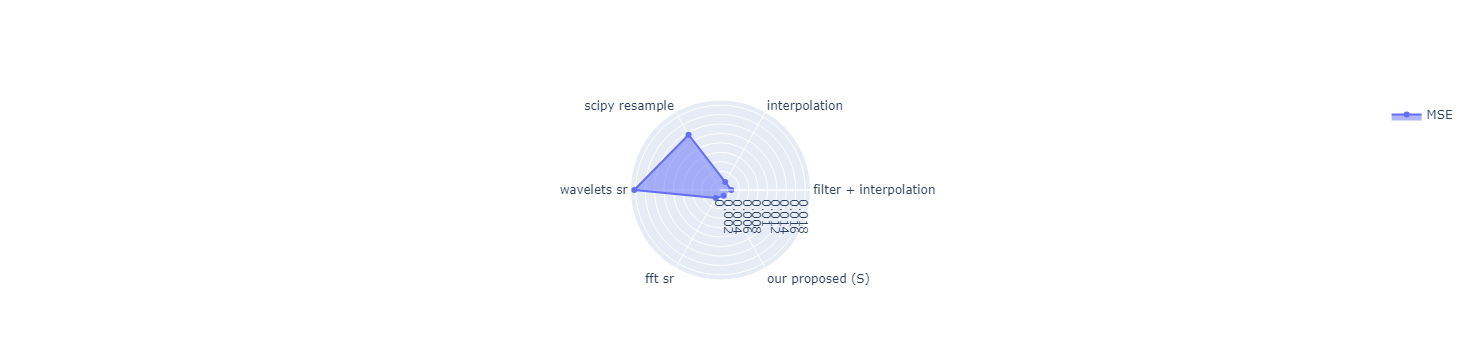

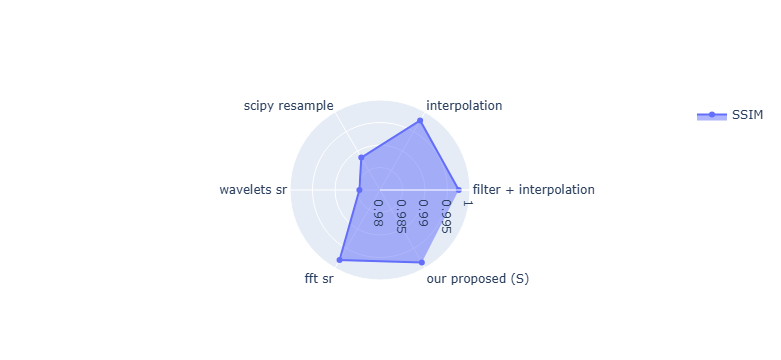

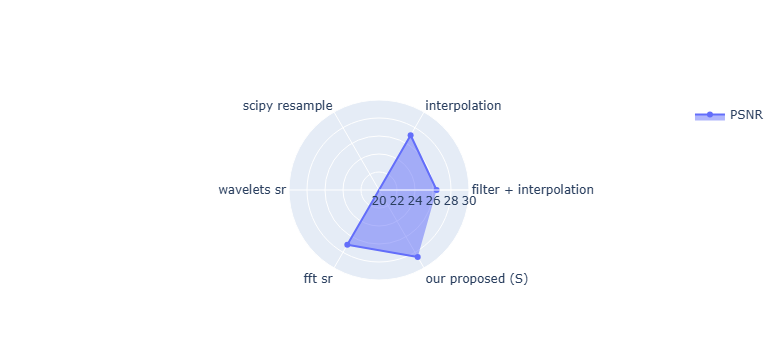

In [42]:
fig = go.Figure()
fig2 = go.Figure()
fig3 = go.Figure()

methods_list = list(methods.keys())
fig.add_trace(go.Scatterpolar(
          r=mses,
          theta=methods_list,
          fill='toself',
          name="MSE"
    ))
fig2.add_trace(go.Scatterpolar(
          r=ssims,
          theta=methods_list,
          fill='toself',
          name="SSIM"
    ))
fig3.add_trace(go.Scatterpolar(
          r=psnrs,
          theta=methods_list,
          fill='toself',
          name="PSNR"
    ))

fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          #range=[0, 1]
        )),
      showlegend=True
    )

fig.show()
fig2.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0.98, 1]
        )),
      showlegend=True
    )

fig2.show()
fig3.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[20, 30]
        )),
      showlegend=True
    )

fig3.show()

In [43]:
df

Method       MSE      SSIM       PSNR  Time (s)
0  filter + interpolation  0.035057  0.985332  15.800933    10.277
1           interpolation  0.185235  0.967726  14.789180     2.470
2          scipy resample  0.184350  0.966256  15.034928   194.731
3             wavelets sr  0.234855  0.980521   9.698363     2.397
4                  fft sr  0.065273  0.978821  13.066146     1.997
5        our proposed (S)  0.005812  0.994214  24.625400    16.238

In [44]:
df.set_index('Method', inplace = True)
df

MSE      SSIM       PSNR  Time (s)
Method                                                         
filter + interpolation  0.035057  0.985332  15.800933    10.277
interpolation           0.185235  0.967726  14.789180     2.470
scipy resample          0.184350  0.966256  15.034928   194.731
wavelets sr             0.234855  0.980521   9.698363     2.397
fft sr                  0.065273  0.978821  13.066146     1.997
our proposed (S)        0.005812  0.994214  24.625400    16.238

In [47]:
results_path = os.getcwd() + os.sep + "results" + os.sep

In [46]:
df.to_csv(results_path+"super_resolution_baseline_signalonly.csv")

In [38]:
def interpolate_width(data, width = 2500, mode = "cubic"):
    width_input = data.shape[-1]
    t_low = np.arange(0, width_input)
    t_high = np.arange(0, width)  #
    f_interp = interpolate.interp1d(t_low, data, kind=mode, fill_value="extrapolate")
    signal_int = f_interp(t_high)
    return signal_int

In [49]:
import time
import pandas as pd 

columns = ["Method", "MSE", "SSIM", "PSNR", "Time (s)"]
model_path = os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr.pt"
model = torch.load(model_path).to(device)
model.eval()

dfs = {}

for label in labels:
    print(label)
    df_noisy = pd.DataFrame(columns = columns)
    
    signals_test = dict_windows_test_lr_n[label]
    signals_test_hr = dict_windows_test_hr[label]
    
    for i, (method, function) in enumerate(methods.items()):

        print(method)

        t0 = time.time()
        #compute method sr from low res
        if method == "sparse_representation_sr":
            signals_test_sr = compute_sr(signals_test, function, signals_hr = signals_test_hr)
        else:
            signals_test_sr = compute_sr(signals_test, function)

        if signals_test_sr.ndim == 3:
            signals_test_sr = torch.unsqueeze(signals_test_sr, dim = 1)

        #compute mse
        mses, mse = compute_mse(signals_test_sr, signals_test_hr)
        #compute ssmi
        ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
        #compute psnr
        psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
        tend = time.time()
        ex_time = round(tend-t0, 3)
        values = [method, mse, ssim, psnr, ex_time]
        df_noisy.loc[i] = values
        print("\n")
        
    dfs[label] = df_noisy
    clear_output()

In [50]:
for label, df_noisy in dfs.items():
    df_noisy.set_index('Method', inplace = True)

In [51]:
dfs["NORM"]

MSE      SSIM       PSNR  Time (s)
Method                                                         
filter + interpolation  0.030185  0.984939  16.327958    17.724
interpolation           0.183834  0.962878  14.920586     4.336
scipy resample          0.182645  0.960624  15.286844   370.491
wavelets sr             0.223409  0.977775  10.198231     4.273
fft sr                  0.052118  0.975099  13.684379     3.625
our proposed (S)        0.003841  0.995544  25.680677    27.794

In [52]:
dfs["MI"]

MSE      SSIM       PSNR  Time (s)
Method                                                         
filter + interpolation  0.035057  0.985332  15.800933    10.191
interpolation           0.185235  0.967726  14.789180     2.525
scipy resample          0.184350  0.966256  15.034928   209.104
wavelets sr             0.234855  0.980521   9.698363     2.426
fft sr                  0.065273  0.978821  13.066146     1.989
our proposed (S)        0.005812  0.994214  24.625400    16.378

In [53]:
dfs["STTC"]

MSE      SSIM       PSNR  Time (s)
Method                                                         
filter + interpolation  0.029562  0.987253  16.655265     5.206
interpolation           0.179424  0.965623  14.542617     1.291
scipy resample          0.178289  0.962666  14.871421   108.834
wavelets sr             0.223839  0.979463   9.938540     1.247
fft sr                  0.055690  0.977418  13.659052     1.041
our proposed (S)        0.005251  0.994452  25.095407     8.366

In [54]:
dfs["HYP"]

MSE      SSIM       PSNR  Time (s)
Method                                                         
filter + interpolation  0.045788  0.988266  14.351607     2.142
interpolation           0.181322  0.974269  13.919638     0.434
scipy resample          0.179013  0.973071  14.272197    46.755
wavelets sr             0.254005  0.984661   8.509058     0.544
fft sr                  0.097376  0.975146  10.919133     0.446
our proposed (S)        0.013945  0.987274  20.574396     3.725

In [55]:
dfs["CD"]

MSE      SSIM       PSNR  Time (s)
Method                                                         
filter + interpolation  0.053439  0.983033  14.677789     4.453
interpolation           0.184918  0.970342  15.364292     1.090
scipy resample          0.184019  0.967566  15.636939    94.084
wavelets sr             0.247137  0.981805   9.449737     1.107
fft sr                  0.098162  0.974577  11.915377     0.890
our proposed (S)        0.013396  0.988932  23.077495     7.241

In [38]:
mses = [0.013396, 0.013945, 0.005251, 0.005812, 0.003841]
mse_mean = np.mean(mses)
rmse = np.sqrt(mse_mean)
mse_mean, rmse

(0.008449, 0.09191844211038391)

In [56]:
labels

['MI', 'STTC', 'CD', 'HYP', 'NORM']

In [77]:
dfs["MI"].to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n & MSE & SSIM & PSNR & Time (s) \\\\\nMethod &  &  &  &  \\\\\n\\midrule\nfilter + interpolation & 0.035057 & 0.985332 & 15.800933 & 10.867000 \\\\\ninterpolation & 0.185235 & 0.967726 & 14.789180 & 2.617000 \\\\\nscipy resample & 0.184350 & 0.966256 & 15.034928 & 153.949000 \\\\\nwavelets sr & 0.234855 & 0.980521 & 9.698363 & 2.561000 \\\\\niterative back projection & 0.042959 & 0.000000 & 14.867909 & 3.800000 \\\\\nfft sr & 0.065273 & 0.978821 & 13.066146 & 2.035000 \\\\\nnon-uniform sr & 0.042959 & 0.000000 & 14.867909 & 2.913000 \\\\\nour proposed (S) & 0.005830 & 0.993867 & 24.546035 & 16.955000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [57]:
results_path = os.getcwd() + os.sep + "results" + os.sep
dfs["MI"].to_csv(results_path+"super_resolution_baseline_signalonly_noisy.csv")

C:\Users\Utente\Schrodinger\PyMOL2\envs\Cambridge\Lib\site-packages\torch\serialization.py:1172: UserWarning:

This figure was saved with matplotlib version 3.8.0 and is unlikely to function correctly.



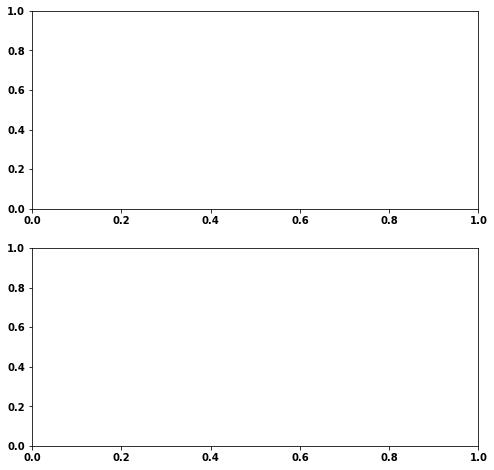

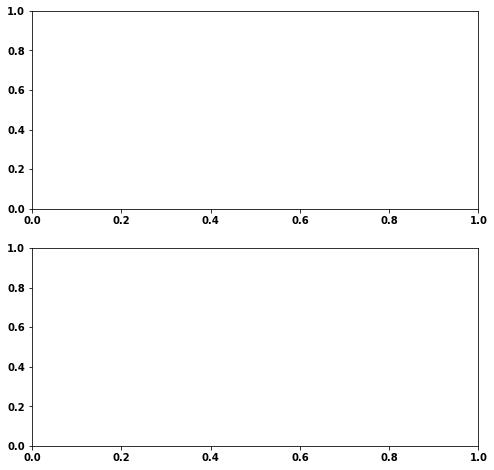

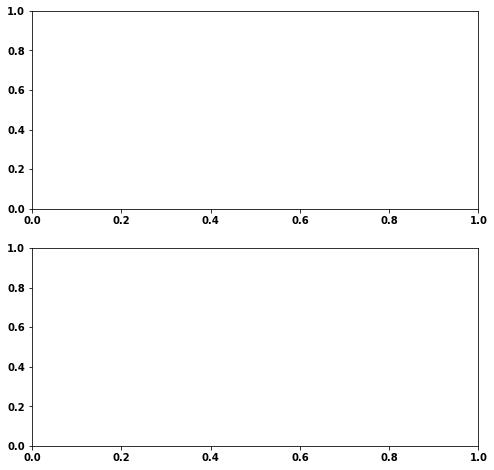

In [58]:
models = {"DCAE": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr.pt").to(device), 
          "CAE": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_nodenoising.pt").to(device)
}

In [59]:
df = pd.DataFrame(columns = ["model", "Noise", "MSE", "SSMI", "PSNR"])
i = 0
noise = [True, False]
label = "MI"

signals_test_hr = dict_windows_test_hr[label]

for name, model in models.items():
    for noise_presence in noise:
        
        if noise_presence:
            signals_test = dict_windows_test_lr_n[label]
        else:
            signals_test = dict_windows_test_lr[label]
            
        signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)
        
        #compute mse
        mses, mse  = compute_mse(signals_test_sr, signals_test_hr)
        #compute ssmi
        ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
        #compute psnr
        psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
        
        values = [name, noise_presence, mse, ssim, psnr]
        df.loc[i] = values
        i+=1

 1088 / 1088

In [60]:
df

model  Noise       MSE      SSMI       PSNR
0  DCAE   True  0.005812  0.994214  24.625400
1  DCAE  False  0.005440  0.994647  25.206207
2   CAE   True  0.068613  0.940977  16.709214
3   CAE  False  0.005644  0.994154  24.770750

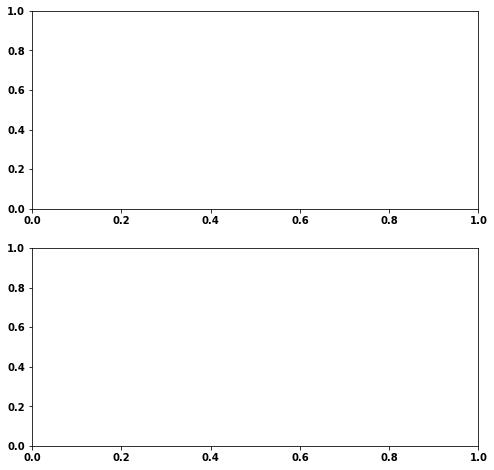

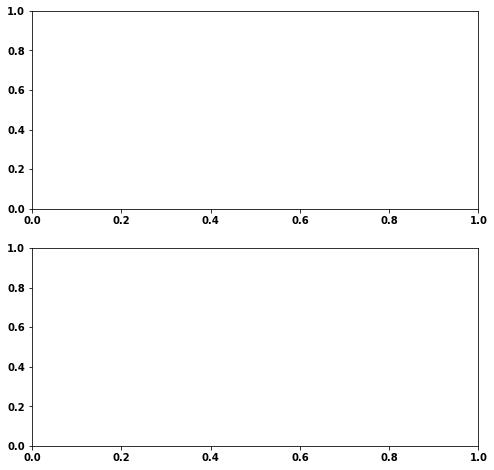

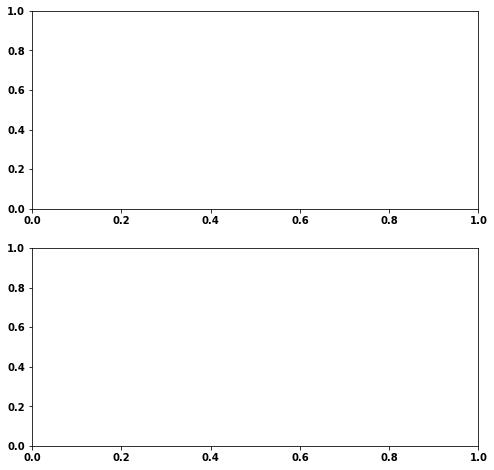

In [61]:
models = {"HR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_hr.pt").to(device), 
          "LR + HR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr.pt").to(device)
}

In [62]:
columns = ["Loss Type", "MSE", "SSIM", "PSNR"]
df = pd.DataFrame(columns = columns)

i = 0
label = "MI"

signals_test_hr = dict_windows_test_hr[label]

for loss_type, model in models.items():
            
    signals_test = dict_windows_test_lr_n[label]
    
    signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)
        
    #compute mse
    mses, mse = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
        
    values = [loss_type, mse, ssim, psnr]
    df.loc[i] = values
    i+=1

df

 1088 / 1088

Loss Type       MSE      SSIM       PSNR
0        HR  0.006947  0.993461  23.449732
1   LR + HR  0.005812  0.994214  24.625400

In [63]:
columns = ["Method", "MSE", "SSIM", "PSNR", "Time (s)"]
df = pd.DataFrame(columns = columns)
df.head()

Empty DataFrame
Columns: [Method, MSE, SSIM, PSNR, Time (s)]
Index: []

In [64]:
def mov_avg_int(data, nchs = 12, window_size = 2):
    
    if data.ndim == 3:
        data = data[0]
    denoised_ecg = []
    for ch in range(nchs):
        data_ch = data[ch, :]
        cumsum = np.cumsum(np.insert(data_ch, 0, 0))
        denoised_ecg.append((cumsum[window_size:] - cumsum[:-window_size]) / window_size)
    denoised_ecg = np.array(denoised_ecg)
    #print(denoised_ecg.shape)
    denoised_ecg = interpolate_width(denoised_ecg, width=250)
    denoised_ecg = interpolate_sr(denoised_ecg)
    #print(denoised_ecg.shape)
    return denoised_ecg

In [65]:
def medianfilt_int(ecg_signal, window_size = 4, nchs = 12):
    
    if ecg_signal.ndim == 3:
        ecg_signal = ecg_signal[0]
    denoised_ecg = np.zeros_like(ecg_signal)
    
    for ch in range(nchs):
        ecg_signal_ch = ecg_signal[ch, :]
        for i in range(len(ecg_signal_ch)):
            start = max(0, i - window_size // 2)
            end = min(len(ecg_signal), i + window_size // 2 + 1)
            denoised_ecg[ch, i] = np.median(ecg_signal[ch, start:end])
    denoised_ecg = np.array(denoised_ecg)
    denoised_ecg = interpolate_width(denoised_ecg, width=250)
    denoised_ecg = interpolate_sr(denoised_ecg)
    return denoised_ecg

In [66]:
import pywt

def wav_int(ecg_signal, nchs = 12, wavelet='db4', level=3):
    
    if ecg_signal.ndim == 3:
        ecg_signal = ecg_signal[0]
        
    denoised_ecg = []
    for ch in range(nchs):
        
        #print(ecg_signal.shape)
        ecg_signal_ch = ecg_signal[ch, :]
        # Decompose the signal using wavelet transform
        coeffs = pywt.wavedec(ecg_signal_ch, wavelet, level=level)

        # Set a threshold for coefficient values
        threshold = 0.2 * max(coeffs[1])

        # Threshold the wavelet coefficients
        coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

        # Reconstruct the denoised signal
        denoised_ecg.append(pywt.waverec(coeffs, wavelet))
    
    denoised_ecg = np.array(denoised_ecg)
    denoised_ecg = interpolate_sr(denoised_ecg)
    return denoised_ecg

In [67]:
from PyEMD import EMD

def emd_int(ecg_signal, nchs = 12):
    
    if ecg_signal.ndim == 3:
        ecg_signal = ecg_signal[0]
        
    denoised_ecg = []
    for ch in range(nchs):
        emd = EMD()
        imfs = emd(ecg_signal[ch, :])
        denoised_ecg.append(np.sum(imfs[:-1], axis=0))  # Sum of IMFs excluding the residue
    
    denoised_ecg = np.array(denoised_ecg)
    denoised_ecg = interpolate_sr(denoised_ecg)
    return denoised_ecg


In [68]:
def fft_int(ecg_signal, nchs = 12):
    pass

In [69]:
methods = ["bandpass filter + interpolation", "wavelet filter + interpolation", "emd filter + interpolation", "median filter + interpolation", "moving average + interpolation", "DCAE-time"]#
functions = [filter_interp, wav_int, emd_int, mov_avg_int, medianfilt_int, mov_avg_int, sr_our_proposed_onlysignals]#  #to add fft_int
methods = {method:functions[i] for i, method in enumerate(methods)}

In [70]:
label = "MI"
signals_test = dict_windows_test_lr_n[label]
signals_test_hr = dict_windows_test_hr[label]

In [71]:
methods

{'bandpass filter + interpolation': <function __main__.filter_interp(signals, nchs=12)>,
 'wavelet filter + interpolation': <function __main__.wav_int(ecg_signal, nchs=12, wavelet='db4', level=3)>,
 'emd filter + interpolation': <function __main__.emd_int(ecg_signal, nchs=12)>,
 'median filter + interpolation': <function __main__.mov_avg_int(data, nchs=12, window_size=2)>,
 'moving average + interpolation': <function __main__.medianfilt_int(ecg_signal, window_size=4, nchs=12)>,
 'DCAE-time': <function __main__.mov_avg_int(data, nchs=12, window_size=2)>}

In [72]:
function = methods["moving average + interpolation"]
signals_test_sr = compute_sr(signals_test, function)
if signals_test_sr.ndim == 3:
    signals_test_sr = torch.unsqueeze(signals_test_sr, dim = 1)
        
mses, mse = compute_mse(signals_test_sr, signals_test_hr)
mse

 2 / 1088

C:\Users\Utente\Schrodinger\PyMOL2\envs\Cambridge\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

C:\Users\Utente\Schrodinger\PyMOL2\envs\Cambridge\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning:

invalid value encountered in divide



 1088 / 1088

nan

In [73]:
import time

columns = ["Method", "MSE", "SSIM", "PSNR", "Time (s)"]
df = pd.DataFrame(columns = columns)
model = models["LR + HR"]
model = model.eval()
model = model.to(device)

label = "MI"

signals_test = dict_windows_test_lr_n[label]
signals_test_hr = dict_windows_test_hr[label]
for i, (method, function) in enumerate(methods.items()):

    print(method, function)

    t0 = time.time()
    #compute method sr from low res

    signals_test_sr = compute_sr(signals_test, function)

    if signals_test_sr.ndim == 3:
        signals_test_sr = torch.unsqueeze(signals_test_sr, dim = 1)
    
    #print(signals_test_sr.shape, signals_test_hr.shape)
    #compute mse
    mses, mse = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
    tend = time.time()
    ex_time = round(tend-t0, 3)
    values = [method, mse, ssim, psnr, ex_time]
    df.loc[i] = values

    del signals_test_sr
    print("\n")

df

bandpass filter + interpolation <function filter_interp at 0x0000019F9A8BA5C0>
 1088 / 1088

wavelet filter + interpolation <function wav_int at 0x000001A08776B2E0>
 1088 / 1088

emd filter + interpolation <function emd_int at 0x000001A018ABFEC0>
 27 / 1088


KeyboardInterrupt



In [ ]:
#change bp freq

C:\Users\Utente\Schrodinger\PyMOL2\envs\Cambridge\Lib\site-packages\torch\serialization.py:1172: UserWarning: This figure was saved with matplotlib version 3.8.0 and is unlikely to function correctly.
  result = unpickler.load()


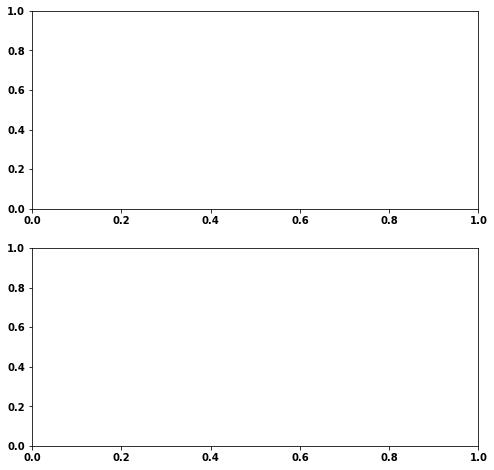

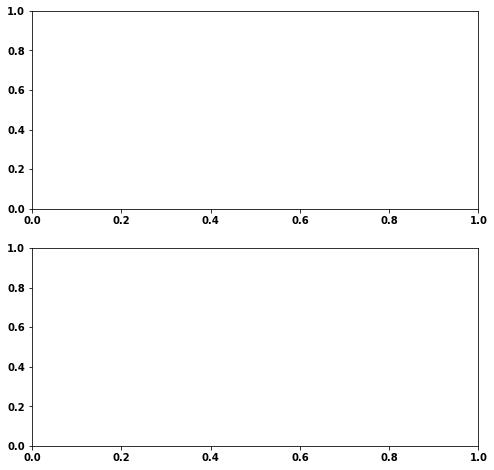

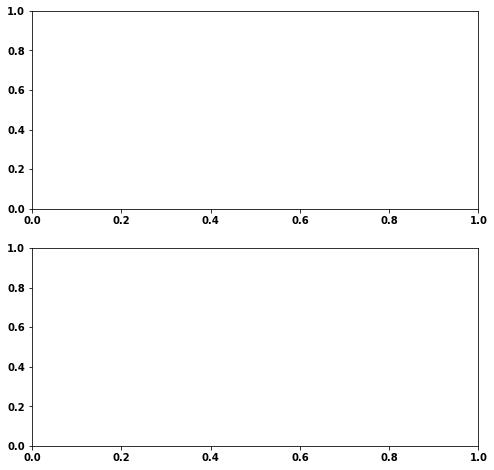

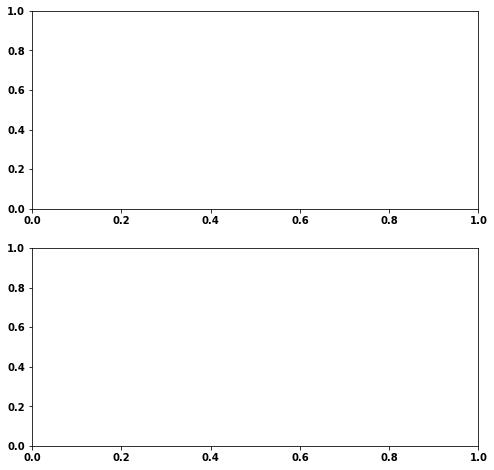

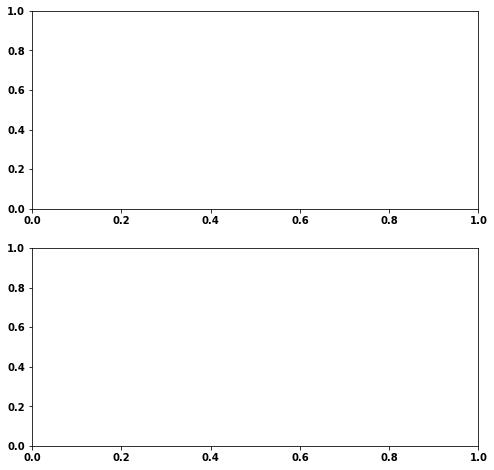

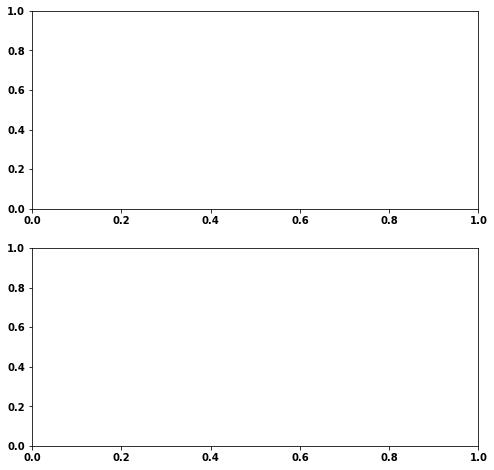

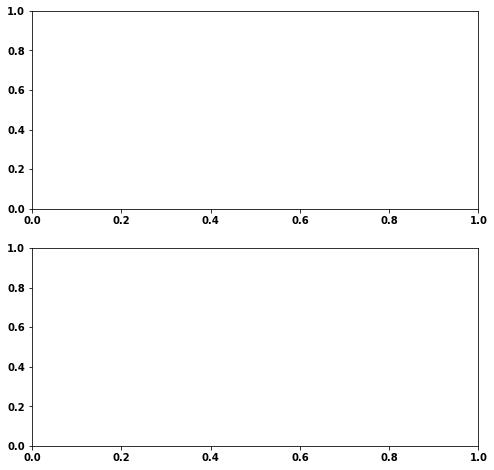

In [45]:
models = {"DCAE_noSR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_nosr.pt").to(device), 
          "DCAE_SR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_denoising_lrhr.pt").to(device), 
          "CAE_noSR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_nodenoising_nosr.pt").to(device),
          "CAE_SR": torch.load(os.getcwd() + os.sep + "models" + os.sep + "model_2_nodenoising.pt").to(device)
}

In [86]:
def compute_nosr(lr_datas, model):
        
    lr_datas = lr_datas.to(device)
    sr_datas = []
    n = len(lr_datas)
    for i, lr_data in enumerate(lr_datas):
        print(i+1, "/", n, end = "\r")
        pred = model([lr_data, None, None, None])
        rec = pred[0]
        sr_data = interpolate_sr(rec.cpu().detach().numpy())
        sr_datas.append(sr_data)
    sr_datas = torch.from_numpy(np.array(sr_datas)).to(device)
    return sr_datas

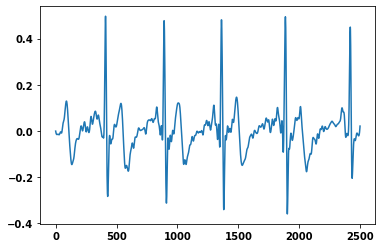

In [85]:
lr_data = dict_windows_test_lr_n[label][0]
pred = model([lr_data, None, None, None])
rec = pred[0].cpu().detach().numpy()
sr_data = interpolate_sr(rec)
plt.plot(sr_data[0, :])

In [87]:
df = pd.DataFrame(columns = ["Denoising", "Super Resolution", "MSE", "SSMI", "PSNR"])
i = 0
label = "MI"

signals_test_hr = dict_windows_test_hr[label]

for name, model in models.items():
    signals_test = dict_windows_test_lr_n[label]
    if "D" in name:
        denoising = "V"
        model.denoising = True
    else:
        denoising = "X"
        model.denoising = False
    if "noSR" in name:
        super_resolution = "X"
    else:
        super_resolution = "V"
        
    if super_resolution == "V":
        signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)
    else:
        signals_test_sr = compute_nosr(signals_test, model)
        
        
    #compute mse
    mses, mse  = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
      
    values = [denoising, super_resolution, mse, ssim, psnr]
    df.loc[i] = values
    i+=1

C:\Users\Utente\AppData\Local\Temp\ipykernel_1476\917586708.py:7: UserWarning: Using a target size (torch.Size([1, 12, 2500])) that is different to the input size (torch.Size([12, 2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(signal_sr, signal_hr)


C:\Users\Utente\AppData\Local\Temp\ipykernel_1476\917586708.py:7: UserWarning: Using a target size (torch.Size([1, 12, 2500])) that is different to the input size (torch.Size([12, 2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(signal_sr, signal_hr)


 1088 / 1088

In [88]:
df

Denoising Super Resolution       MSE      SSMI       PSNR
0         V                X  0.007329  0.993879  22.996780
1         V                V  0.005812  0.994214  24.625400
2         X                X  0.136264  0.916896  14.170322
3         X                V  0.068613  0.940977  16.709214

In [74]:
len(methods.keys())

6

In [75]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "24"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = "24"

In [82]:
good = list(df_noisy[df_noisy["SSIM"] != 0.0].index)
good

['filter + interpolation',
 'interpolation',
 'scipy resample',
 'wavelets sr',
 'fft sr',
 'our proposed (S)']

filter + interpolation
torch.Size([1, 1, 12, 250]) torch.Size([1, 1, 12, 2500])
 1 / 1interpolation
torch.Size([1, 1, 12, 250]) torch.Size([1, 1, 12, 2500])
 1 / 1scipy resample
torch.Size([1, 1, 12, 250]) torch.Size([1, 1, 12, 2500])
 1 / 1wavelets sr
torch.Size([1, 1, 12, 250]) torch.Size([1, 1, 12, 2500])
 1 / 1fft sr
our proposed (S)
torch.Size([1, 1, 12, 250]) torch.Size([1, 1, 12, 2500])
 1 / 1

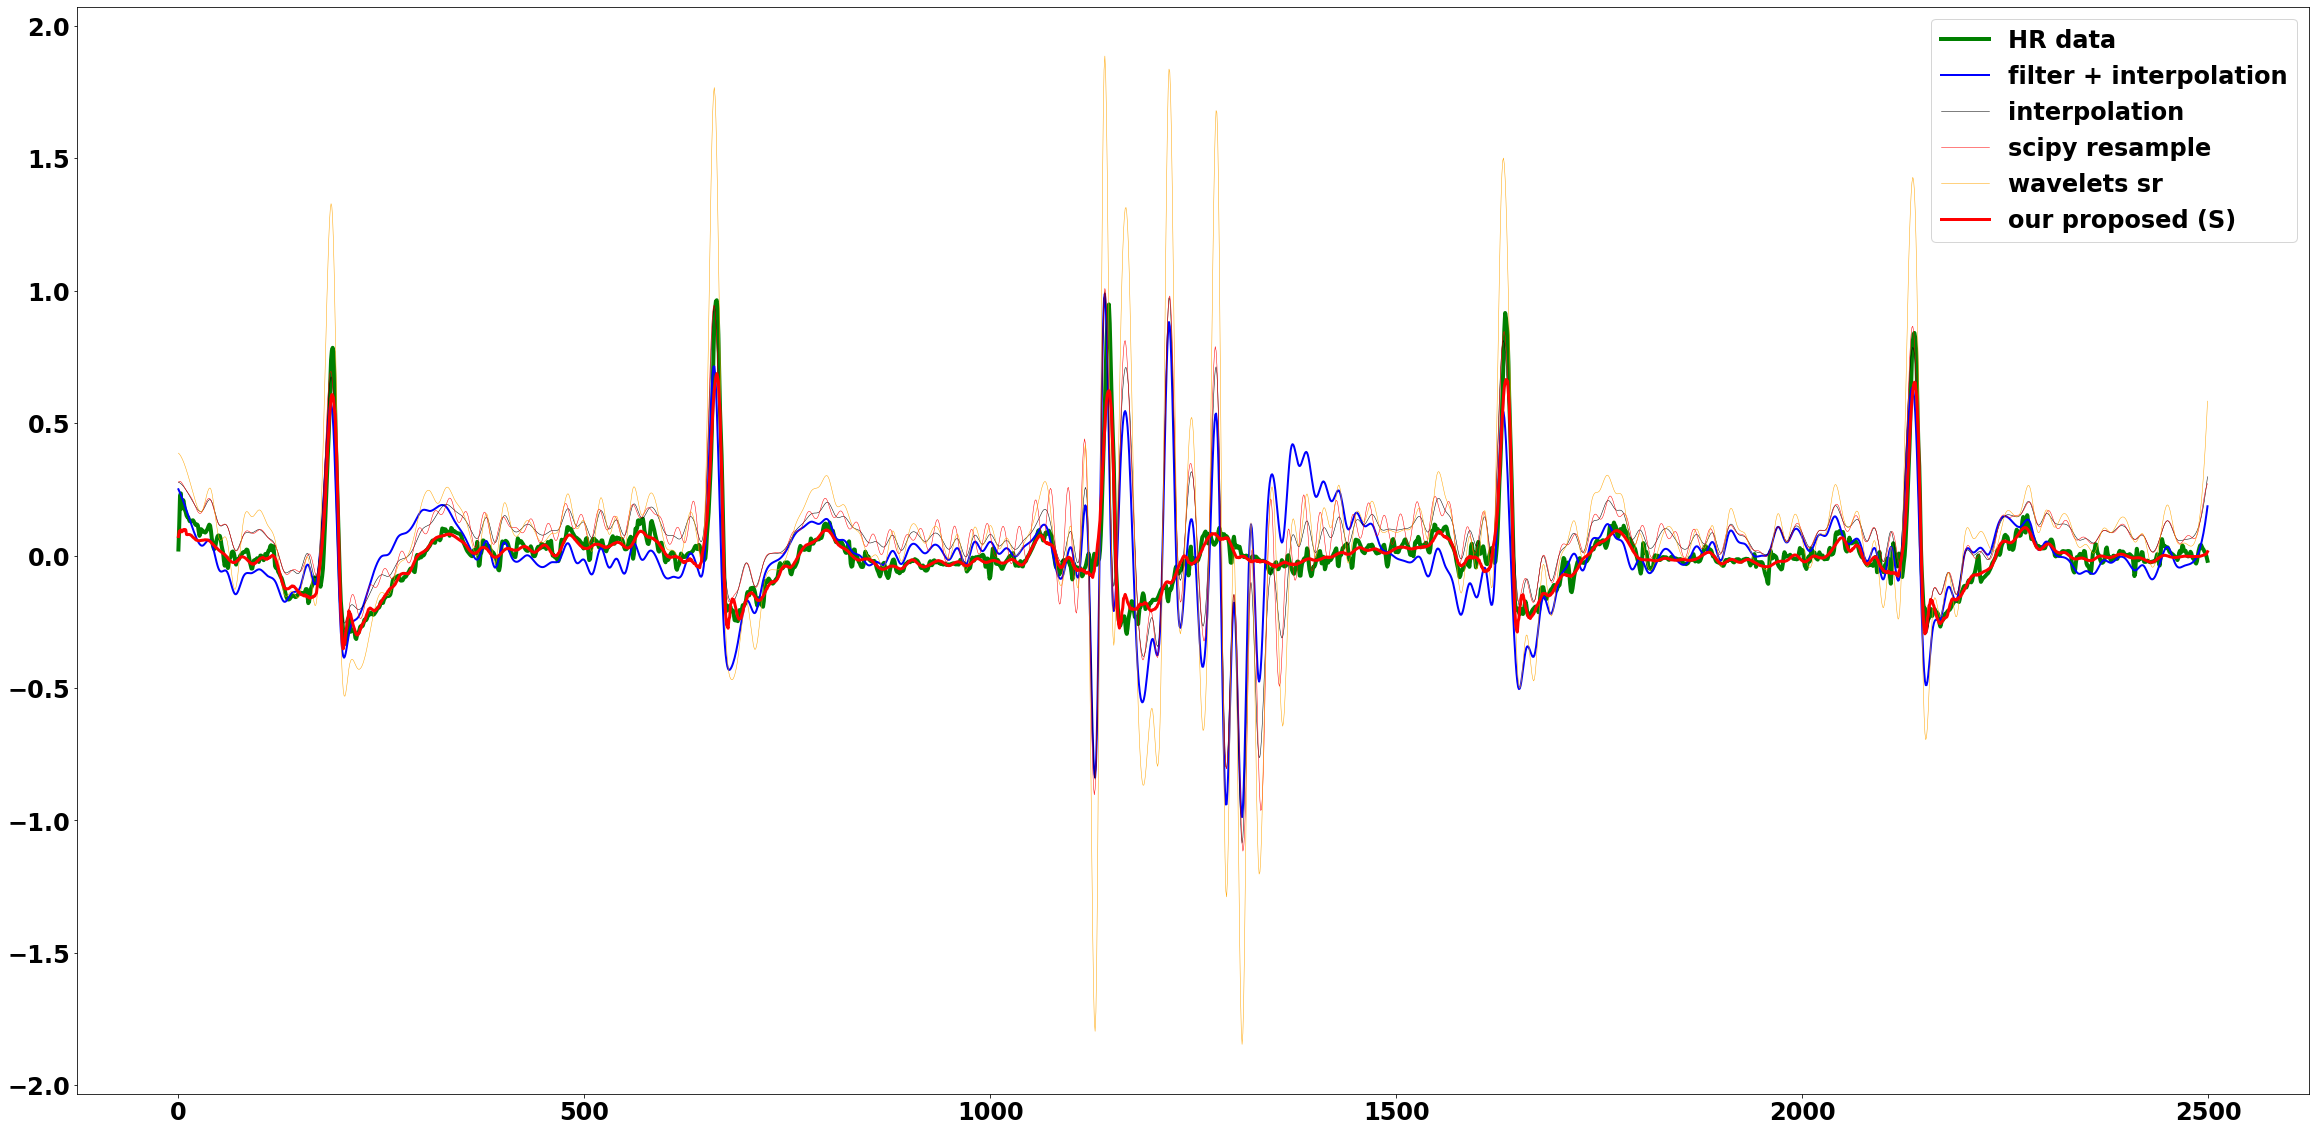

In [83]:
idx = 520
nchs = 12
ch = 0
label = "MI"
lr_data = dict_windows_test_lr_n[label][idx][ch].cpu()#dict_windows_test_lr_n[label][idx][ch].cpu()
hr_data = dict_windows_test_hr[label][idx][ch].cpu()
fig = plt.figure(figsize = (40, 20))
model = models["LR + HR"]

colors = ["green", "blue", "black", "red", "orange", "red"]
skips = ["fft sr"]
while True:
    if lr_data.ndim == 4:
        break
    else:
        lr_data = torch.unsqueeze(lr_data, dim = 0)

while True:
    if hr_data.ndim == 4:
        break
    else:
        hr_data = torch.unsqueeze(hr_data, dim = 0)

i = 0
plt.plot(hr_data[0, 0, ch, :], color = colors[0], label = "HR data", linewidth = 4)
i+=1       

for (method, function) in methods.items():
    
    print(method)
    if method in good and method not in skips:
        print(lr_data.shape, hr_data.shape)
        #compute method sr from low res
        if method == "sparse_representation_sr":
            sr_data = compute_sr(lr_data, function, signals_hr = hr_data)
        else:
            sr_data = compute_sr(lr_data, function)

        if sr_data.ndim == 3:
            sr_data = torch.unsqueeze(sr_data, dim = 1)

        color = colors[i]
        if method == "our proposed (S)":
            linewidth = 3
        elif method == "filter + interpolation":
            linewidth = 2
        else:
            linewidth = 0.5
        plt.plot(sr_data[0, 0, ch, :], color = color, label = method, linewidth = linewidth)
        i+=1
plt.legend()

In [84]:
fig.savefig("sr_EMGnoise_comparison.png", dpi=600)

(2500,)


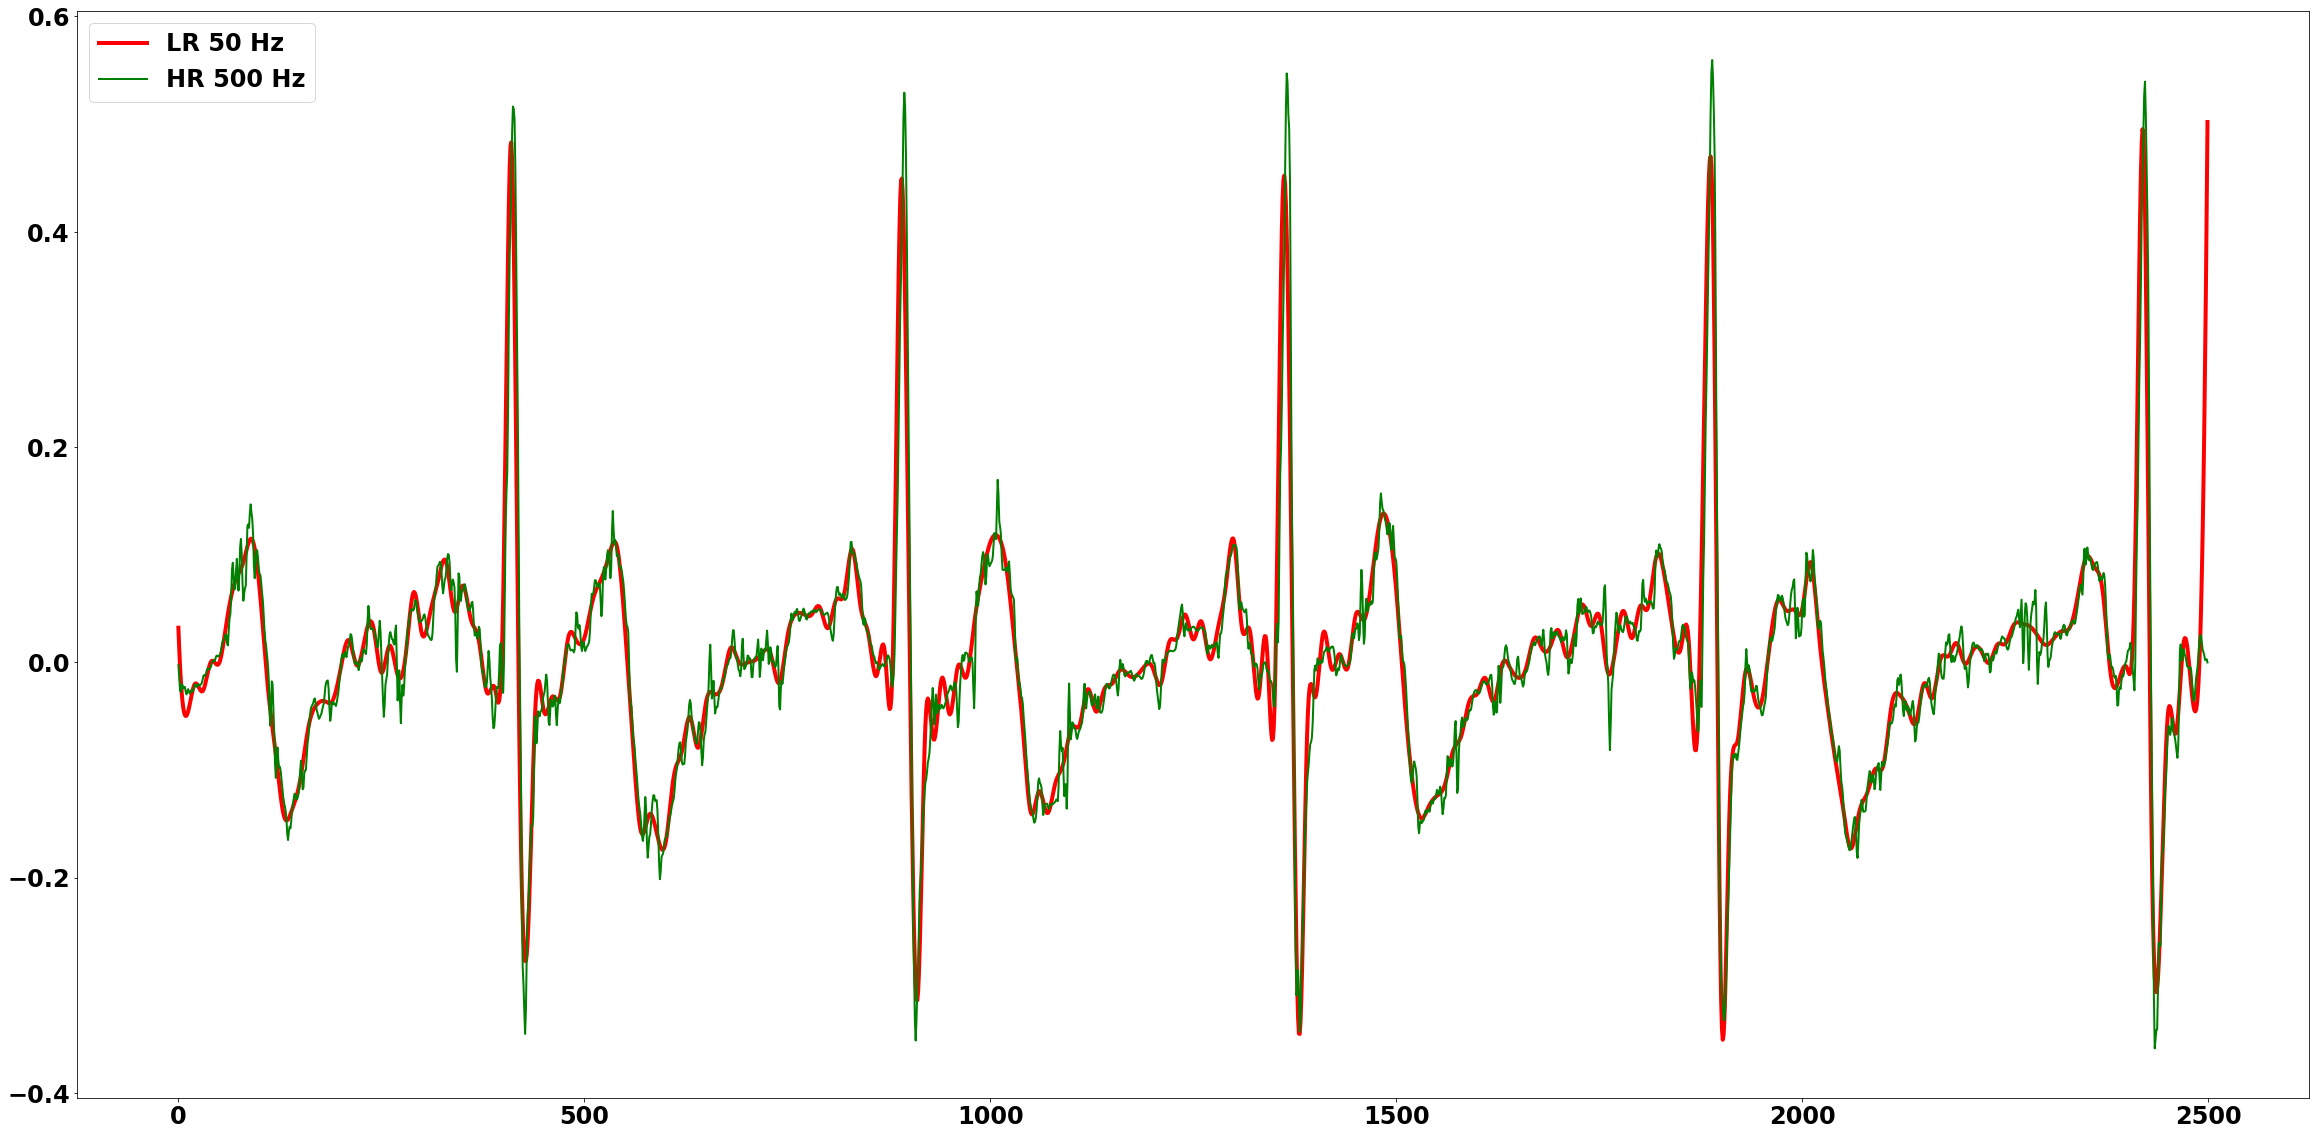

In [85]:
idx = 0
ch = 0
label = "MI"
lr_data = dict_windows_test_lr_n[label][idx][0, 0].cpu()
hr_data = dict_windows_test_hr[label][idx][0, 0].cpu()
fs_lr = 50
fs_hr = 500
t_low_res = np.arange(0, 5, 1/fs_lr)
t_high_res = np.arange(0, 5, 1/fs_hr)
f_interp = interpolate.interp1d(t_low_res, lr_data, kind='cubic', fill_value="extrapolate")
lr_up = f_interp(t_high_res)
fig = plt.figure(figsize = (40, 20))
colors = ["r", "g"]
print(lr_up.shape)
datas = [lr_up, hr_data]
labels = ["LR 50 Hz", "HR 500 Hz"]
widths = [4, 2]
for i, data in enumerate(datas):
    label = labels[i]
    color = colors[i]
    width = widths[i]
    plt.plot(data, color = color, label = label, linewidth = width)
plt.legend()

In [86]:
signals_test.shape

torch.Size([1088, 1, 12, 250])

In [67]:
label = "MI"
signals_test = dict_windows_test_lr_n[label]
model = models["DCAE"]
interpolation_modes = ["linear", "nearest", "nearest-up", "zero", "slinear", "quadratic", "cubic", "previous", "next"]
df2 = pd.DataFrame(columns=columns)
for i, mode in enumerate(interpolation_modes):

    print(mode)
    t0 = time.time()

    signals_test_sr = interpolate_sr(signals_test.cpu(), fs_lr=50, fs_hr = 500, nchs=12, mode = mode)

    #compute mse
    mses, mse = compute_mse(signals_test_sr, signals_test_hr)
    #compute ssmi
    ssims, ssim = compute_ssim(signals_test_sr, signals_test_hr)
    #compute psnr
    psnrs, psnr = compute_psnr(signals_test_sr, signals_test_hr)
    tend = time.time()
    ex_time = round(tend-t0, 3)
    values = [mode, mse, ssim, psnr, ex_time]
    df2.loc[i] = values
df2

linear
nearest
nearest-up
zero
slinear
quadratic
cubic
previous
next


Method       MSE      SSIM       PSNR  Time (s)
0      linear  0.183642  0.963952  14.831941     2.224
1     nearest  0.188369  0.961090  13.677280     1.654
2  nearest-up  0.189529  0.960622  13.393217     1.631
3        zero  0.190534  0.960136  13.067753     1.867
4     slinear  0.183642  0.963952  14.831941     1.924
5   quadratic  0.184549  0.965710  14.904421     2.108
6       cubic  0.185235  0.967726  14.789180     2.207
7    previous  0.190534  0.960136  13.067753     1.670
8        next       NaN       NaN        NaN     1.659

In [68]:
t0 = time.time()
signals_test_sr = compute_sr(signals_test, sr_our_proposed_onlysignals)

if signals_test_sr.ndim == 3:
  signals_test_sr = torch.unsqueeze(signals_test_sr, dim = 1)

#compute mse
mse = compute_mse(signals_test_sr, signals_test_hr)
#compute ssmi
ssim = compute_ssim(signals_test_sr, signals_test_hr)
#compute psnr
psnr = compute_psnr(signals_test_sr, signals_test_hr)
tend = time.time()
ex_time = round(tend-t0, 3)
values = ["our proposed (S)", mse, ssim, psnr, ex_time]
df2.loc[i+1] = values

 1088 / 1088

In [69]:
df2.set_index('Method', inplace = True)
df2

MSE      SSIM       PSNR  Time (s)
Method                                                   
linear            0.183642  0.963952  14.831941     2.224
nearest           0.188369  0.961090  13.677280     1.654
nearest-up        0.189529  0.960622  13.393217     1.631
zero              0.190534  0.960136  13.067753     1.867
slinear           0.183642  0.963952  14.831941     1.924
quadratic         0.184549  0.965710  14.904421     2.108
cubic             0.185235  0.967726  14.789180     2.207
previous          0.190534  0.960136  13.067753     1.670
next                   NaN       NaN        NaN     1.659
our proposed (S)  0.005830  0.993867  24.546035    16.310

In [71]:
results_path = os.getcwd() + os.sep + "results" + os.sep
df2.to_csv(results_path+"super_resolution_baseline_interpolation_signalonly.csv")

 1 / 1

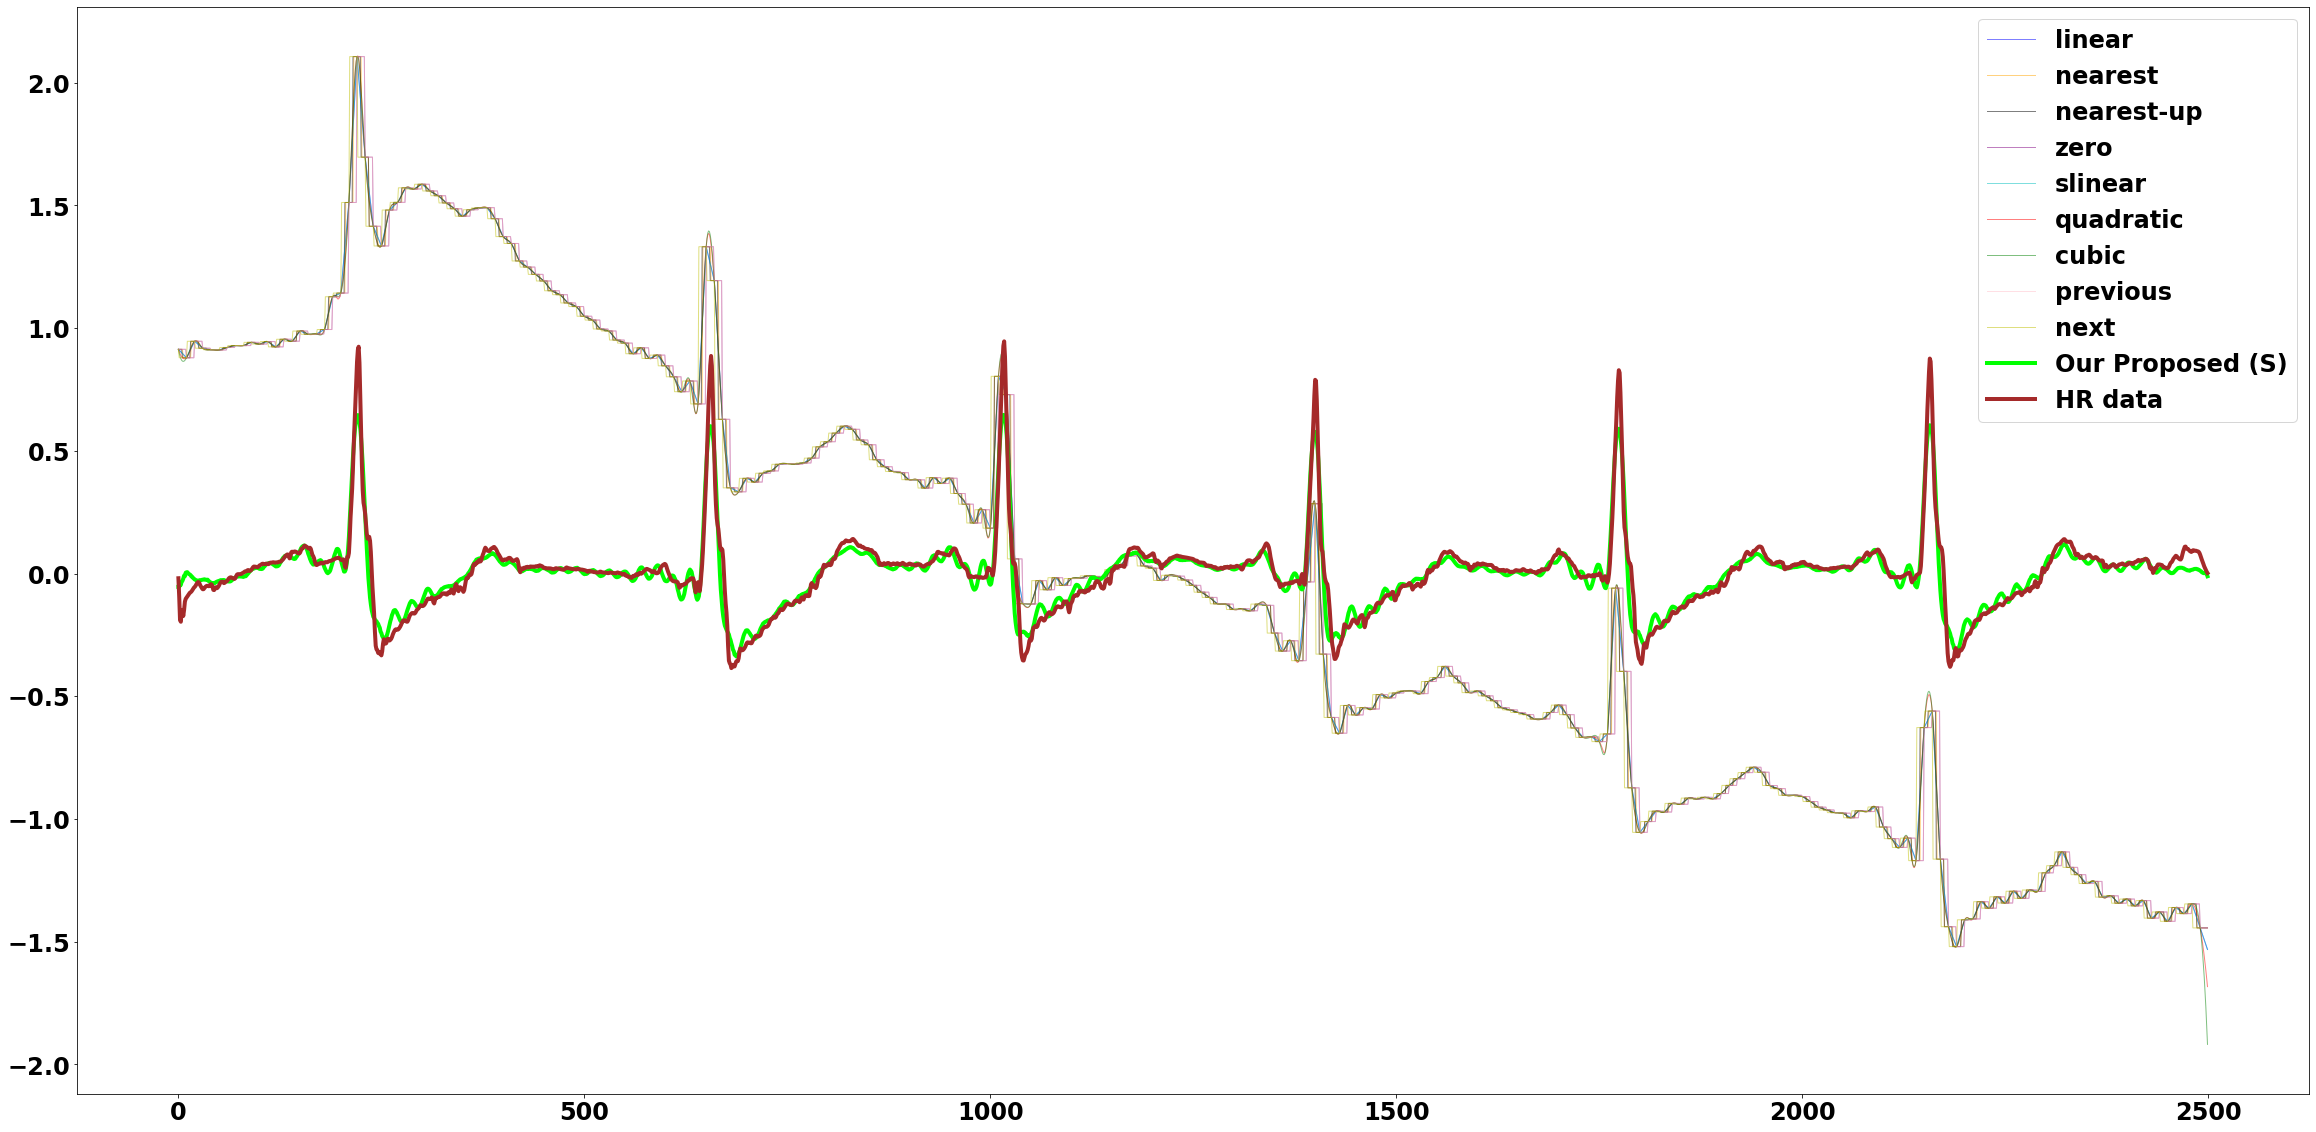

In [72]:
idx = 150
nchs = 12
ch = 0
label = "MI"
lr_data = dict_windows_test_lr_n[label][idx][ch].cpu()
hr_data = dict_windows_test_hr[label][idx][ch].cpu()
fig = plt.figure(figsize = (40, 20))

colors = ["b", "orange", "k", "purple", "c", "r", "g", "pink", "y", "brown", "lime"]

while True:
    if lr_data.ndim == 4:
        break
    else:
        lr_data = torch.unsqueeze(lr_data, dim = 0)

while True:
    if hr_data.ndim == 4:
        break
    else:
        hr_data = torch.unsqueeze(hr_data, dim = 0)

for i, mode in enumerate(interpolation_modes):

    sr_data = interpolate_sr(lr_data, fs_lr=50, fs_hr = 500, nchs=12, mode = mode)
    color = colors[i]
    plt.plot(sr_data[0, 0, ch, :], color = color, label = mode, linewidth = 1, alpha = 0.5)

sr_data = compute_sr(lr_data, sr_our_proposed_onlysignals)
plt.plot(sr_data[0, 0, ch, :], color = colors[-1], label = "Our Proposed (S)", linewidth = 4)
plt.plot(hr_data[0, 0, ch, :], color = colors[-2], label = "HR data", linewidth = 4)
plt.legend()

# Wavelets super resolution

In [ ]:
dict_train_wavelets_lr = {}
dict_train_wavelets_hr = {}
dict_test_wavelets_lr = {}
dict_test_wavelets_hr = {}
pt_data_path = os.getcwd() + os.sep + "wavelets"
labels = ["MI"] #per ora solo uno

for label in labels:

    print(label)
    filename = pt_data_path+ os.sep + "train_wavelets_{}.pt".format(label)
    print("train LR")
    train_lr = torch.load(filename)
    dict_train_wavelets_lr[label] = train_lr

    filename = pt_data_path+ os.sep + "train_wavelets_{}_hr.pt".format(label)
    print("train HR")
    train_hr = torch.load(filename)
    dict_train_wavelets_hr[label] = train_hr


    filename = pt_data_path+ os.sep + "test_wavelets_{}.pt".format(label)
    print("test LR")
    test_lr = torch.load(filename)
    dict_test_wavelets_lr[label] = test_lr

    filename = pt_data_path+ os.sep + "test_wavelets_{}_hr.pt".format(label)
    print("test HR")
    test_hr = torch.load(filename)
    dict_test_wavelets_hr[label] = test_hr

MI
train LR
train HR
test LR
test HR


In [ ]:
len(t_low_res), len(y)

(500, 97)

In [106]:
def signalPower(x):
    return np.average(x**2)

def SNR(sr, hr):
        
    noise = sr-hr
    powT = signalPower(hr)
    powN = signalPower(noise)
    return 10*np.log10(powT/powN)

In [108]:
idx = 0
lr_data = dict_windows_test_lr_n[label][idx]
hr_data = dict_windows_test_hr[label][idx]
preds = model([lr_data, None])
sr = preds[1]
snr_db =  SNR(sr.cpu().detach().numpy(), hr_data.cpu().detach().numpy())
snr_db

11.49458646774292

In [112]:
snrs = []
for label in labels:
    print(label)
    x_lr = dict_windows_test_lr_n[label]
    for i, lr_data in enumerate(x_lr):
        hr_data = dict_windows_test_hr[label][i]
        preds = model([lr_data, None])
        sr = preds[1]
        snr_db =  SNR(sr.cpu().detach().numpy(), hr_data.cpu().detach().numpy())
        snrs.append(snr_db)

MI
STTC
CD
HYP
NORM


In [113]:
np.mean(snrs)

9.798864273369947